<a href="https://colab.research.google.com/github/sayanbanerjee32/coreference-resolution/blob/main/data_explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Papers and blogs

End2End Coref Resolution By Attention RNN - https://www.kaggle.com/keyit92/end2end-coref-resolution-by-attention-rnn  
coreference-resolution - https://www.kaggle.com/abhishekbhole/coreference-resolution  
SpanBERT - https://arxiv.org/pdf/1907.10529.pdf   
BERT for Coreference Resolution - https://arxiv.org/pdf/1908.09091.pdf  
GITHub for BERT and SpanBERT - https://github.com/mandarjoshi90/coref  
Fast AI solution - https://www.kaggle.com/mamamot/fastai-awd-lstm-solution-0-71-lb/notebook

In [1]:
%%capture
!pip install fastai -Uq

In [2]:
# mount gdrive for data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
# file locations
train_file_path = '/content/drive/MyDrive/coref_resolution/data/gap-development.tsv'
val_file_path = '/content/drive/MyDrive/coref_resolution/data/gap-validate.tsv'
test_file_path = '/content/drive/MyDrive/coref_resolution/data/gap-test.tsv'
model_save_path = '/content/drive/MyDrive/coref_resolution/models/'

In [26]:
import pandas as pd
from fastai.text.all import *
from pathlib import Path

In [13]:
train_df = pd.read_csv(train_file_path,sep="\t")
test_df = pd.read_csv(test_file_path,sep="\t")
val_df = pd.read_csv(val_file_path,sep="\t")

In [14]:
train_df["Text"][0], train_df["Text"][1]

("Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.",
 'He grew up in Evanston, Illinois the second oldest of five children including his brothers, Fred and Gordon and sisters, Marge (Peppy) and Marilyn. His high school days were spent at New Trier High School in Winnetka, Illinois. MacKenzie studied with Bernard Leach from 1949 to 1952. His simple, wheel-thrown functional pottery is heavily influenced by the oriental aesthetic of Shoji Hamada and Kanjiro Kawai.')

In [15]:
print(len(train_df), len(val_df), len(test_df))

2000 454 2000


## Fine tune language model

In [16]:
# lets keep val for final testing
df_pretrain = pd.concat([train_df, test_df])
df_pretrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              4000 non-null   object
 1   Text            4000 non-null   object
 2   Pronoun         4000 non-null   object
 3   Pronoun-offset  4000 non-null   int64 
 4   A               4000 non-null   object
 5   A-offset        4000 non-null   int64 
 6   A-coref         4000 non-null   bool  
 7   B               4000 non-null   object
 8   B-offset        4000 non-null   int64 
 9   B-coref         4000 non-null   bool  
 10  URL             4000 non-null   object
dtypes: bool(2), int64(3), object(6)
memory usage: 320.3+ KB


In [19]:
# fine tune language model
data_lm = DataBlock(
            blocks=TextBlock.from_df('Text', is_lm=True),
            get_x=ColReader('text'),
            splitter=RandomSplitter(0.1))

dls_lm = data_lm.dataloaders(df_pretrain) 
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj this acquisition secured communication with xxmaj henry for the future . xxmaj in the fall of xxrep 3 1 0 xxmaj pedro placed his wife , xxmaj mayor xxmaj rodr*guez , and his ward , xxmaj alfonso , in his newly acquired castle . xxmaj one of the queen 's supporters , a minor nobleman named xxmaj arias xxmaj p*rez , attacked suddenly and forced xxmaj pedro to retreat ,","xxmaj this acquisition secured communication with xxmaj henry for the future . xxmaj in the fall of xxrep 3 1 0 xxmaj pedro placed his wife , xxmaj mayor xxmaj rodr*guez , and his ward , xxmaj alfonso , in his newly acquired castle . xxmaj one of the queen 's supporters , a minor nobleman named xxmaj arias xxmaj p*rez , attacked suddenly and forced xxmaj pedro to retreat , leaving"
1,". xxmaj in 1962 , xxmaj signoret translated xxmaj lillian xxmaj xxunk 's play xxmaj the xxmaj little xxmaj xxunk into xxmaj french for a production in xxmaj paris that ran for six months at the xxmaj theatre sarah - xxunk . xxmaj she played the xxmaj regina role as well . xxbos xxmaj in 2011 , xxmaj jonas xxmaj xxunk xxmaj xxunk , the then xxmaj foreign xxmaj minister of xxmaj","xxmaj in 1962 , xxmaj signoret translated xxmaj lillian xxmaj xxunk 's play xxmaj the xxmaj little xxmaj xxunk into xxmaj french for a production in xxmaj paris that ran for six months at the xxmaj theatre sarah - xxunk . xxmaj she played the xxmaj regina role as well . xxbos xxmaj in 2011 , xxmaj jonas xxmaj xxunk xxmaj xxunk , the then xxmaj foreign xxmaj minister of xxmaj norway"


In [22]:
# create language model learner
learn_lm = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.5, pretrained=True, 
    metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(valley=0.010964781977236271)

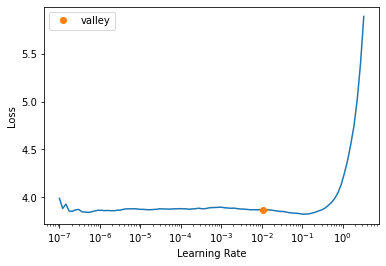

In [23]:
# find optimum learning rate for language model
learn_lm.lr_find()

In [24]:
# one cycle training
learn_lm.fit_one_cycle(1, 0.01)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.587253,3.362264,0.376563,28.854448,00:20


In [28]:
# unfreeze all the layers and one cycle training
learn_lm.unfreeze()
learn_lm.fit_one_cycle(5, 0.01)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.184223,3.625756,0.339757,37.553093,00:20
1,3.249936,3.667060,0.346159,39.136681,00:20
2,2.845441,3.711971,0.350977,40.934402,00:20
3,2.227012,3.883855,0.351150,48.611233,00:21
4,1.661404,4.055688,0.343642,57.724857,00:20


In [30]:
# save language model
learn_lm.save_encoder(Path(model_save_path) /'lm_fine_tuned')